In [158]:
import os
import glob
import shutil
import pandas as pd
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
from src.helper import *

In [159]:
!pwd

/Users/hyorimlee/Desktop/gNYC13/capstone3/AgeGenderClassification


In [160]:
# os.chdir('gNYC13/capstone3/AgeGenderClassification')

In [161]:
# #Move all the images into one single directory. 

# for subdir, dirs,files in os.walk("data/faces", topdown=False):
#     for f in files:
#         os.rename(os.path.join(subdir,f),os.path.join("data/f2/",f))

In [162]:
# #Delete .txt files (unnecessary)

# files = glob.glob(os.path.join('data/f2/*.txt'))
# for file in files:
#     os.remove(file)

In [82]:
fold0 = pd.read_csv('data/data0.txt',sep='\t')
fold1 = pd.read_csv('data/data1.txt',sep='\t')
fold2 = pd.read_csv('data/data2.txt',sep='\t')
fold3 = pd.read_csv('data/data3.txt',sep='\t')
fold4 = pd.read_csv('data/data4.txt',sep='\t')

In [83]:
data = pd.concat([fold0,fold1,fold2,fold3,fold4], ignore_index=True)

In [84]:
(fold0.shape[0] + fold1.shape[0] + fold2.shape[0] +fold3.shape[0] +fold4.shape[0]) == data.shape[0]

True

In [85]:
data.shape

(19370, 12)

In [86]:
data.head()

,user_id,original_image,face_id,age,gender,x,y,dx,dy,tilt_ang,fiducial_yaw_angle,fiducial_score
0,30601258@N03,10399646885_67c7d20df9_o.jpg,1,"(25, 32)",f,0,414,1086,1383,-115,30,17
1,30601258@N03,10424815813_e94629b1ec_o.jpg,2,"(25, 32)",m,301,105,640,641,0,0,94
2,30601258@N03,10437979845_5985be4b26_o.jpg,1,"(25, 32)",f,2395,876,771,771,175,-30,74
3,30601258@N03,10437979845_5985be4b26_o.jpg,3,"(25, 32)",m,752,1255,484,485,180,0,47
4,30601258@N03,11816644924_075c3d8d59_o.jpg,2,"(25, 32)",m,175,80,769,768,-75,0,34


In [87]:
df = data[['age', 'gender', 'x', 'y', 'dx', 'dy']].copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19370 entries, 0 to 19369
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   age     19370 non-null  object
 1   gender  18591 non-null  object
 2   x       19370 non-null  int64 
 3   y       19370 non-null  int64 
 4   dx      19370 non-null  int64 
 5   dy      19370 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 908.1+ KB


In [88]:
img_path = []

In [89]:
for row in data.iterrows():
    path = "data/f2/coarse_tilt_aligned_face."+str(row[1].face_id)+"."+row[1].original_image
    img_path.append(path)

df['img_path'] = img_path

In [90]:
df.head()

,age,gender,x,y,dx,dy,img_path
0,"(25, 32)",f,0,414,1086,1383,data/f2/coarse_tilt_aligned_face.1.10399646885...
1,"(25, 32)",m,301,105,640,641,data/f2/coarse_tilt_aligned_face.2.10424815813...
2,"(25, 32)",f,2395,876,771,771,data/f2/coarse_tilt_aligned_face.1.10437979845...
3,"(25, 32)",m,752,1255,484,485,data/f2/coarse_tilt_aligned_face.3.10437979845...
4,"(25, 32)",m,175,80,769,768,data/f2/coarse_tilt_aligned_face.2.11816644924...


In [91]:
age_mapping = [('(0, 2)', '0-2'), ('2', '0-2'), ('3', '0-2'), ('(4, 6)', '4-6'), ('(8, 12)', '8-13'), ('13', '8-13'), ('22', '15-20'), ('(8, 23)','15-20'), ('23', '25-32'), ('(15, 20)', '15-20'), ('(25, 32)', '25-32'), ('(27, 32)', '25-32'), ('32', '25-32'), ('34', '25-32'), ('29', '25-32'), ('(38, 42)', '38-43'), ('35', '38-43'), ('36', '38-43'), ('42', '48-53'), ('45', '38-43'), ('(38, 43)', '38-43'), ('(38, 42)', '38-43'), ('(38, 48)', '48-53'), ('46', '48-53'), ('(48, 53)', '48-53'), ('55', '48-53'), ('56', '48-53'), ('(60, 100)', '60+'), ('57', '60+'), ('58', '60+')]

age_mapping_dict = {each[0]: each[1] for each in age_mapping}
drop_labels = []
for idx, each in enumerate(df.age):
    if each == 'None':
        drop_labels.append(idx)
    else:
        df.age.loc[idx] = age_mapping_dict[each]

df = df.drop(labels=drop_labels, axis=0) #droped None values
df.age.value_counts(dropna=True)

/Users/hyorimlee/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


25-32    5296
38-43    2776
0-2      2509
8-13     2292
4-6      2140
15-20    1792
48-53     916
60+       901
Name: age, dtype: int64

## AGE DATASETS - TRAIN, TEST, VALIDATION (70, 15, 15)

In [38]:
# To use VGG16 / VGG19, I have to separate every image into the right directory.

In [39]:
X_train, X_test, y_train, y_test = train_test_split(df.img_path, df.age, test_size = .3)

In [40]:
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5)

In [41]:
len(X_train)

13035

In [42]:
len(X_test)

2793

In [43]:
len(X_val)

2794

In [126]:
# iden = 0
# for line,gen in zip(X_train,y_train):
#     os.rename (line, 'data/f2/age/train/'+gen+'/'+str(iden)+'.jpg')
#     iden += 1
# iden = 0
# for line,gen in zip(X_test,y_test):
#     os.rename (line, 'data/f2/age/test/'+gen+'/'+str(iden)+'.jpg')
#     iden += 1
# iden = 0
# for line,gen in zip(X_val,y_val):
#     os.rename (line, 'data/f2/age/validation/'+gen+'/'+str(iden)+'.jpg')
#     iden += 1

## GENDER DATASETS - TRAIN, TEST, VALIDATION (70, 15, 15)

In [93]:
X_train, X_test, y_train, y_test = train_test_split(df.img_path, df.gender, test_size = .3)

In [94]:
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5)

In [95]:
len(X_train)

13035

In [96]:
len(X_test) , len(X_val)

(2793, 2794)

In [98]:
y_test.unique()

array(['m', 'f', 'u', nan], dtype=object)

In [127]:

# iden = 0
# for line,gen in zip(X_train,y_train):
#     os.rename (line, 'data/f2/gender/train/'+str(gen)+'/'+str(iden)+'.jpg')
#     iden += 1
# iden = 0
# for line,gen in zip(X_test,y_test):
#     os.rename (line, 'data/f2/gender/test/'+str(gen)+'/'+str(iden)+'.jpg')
#     iden += 1
# iden = 0
# for line,gen in zip(X_val,y_val):
#     os.rename (line, 'data/f2/gender/validation/'+str(gen)+'/'+str(iden)+'.jpg')
#     iden += 1

In [153]:
root = 'data/f2'

In [157]:
#DataSets
list_files(root)

f2/
    gender/
        test/
            f/
            m/
        train/
            f/
            m/
        validation/
            f/
            m/
    age/
        test/
            15-20/
            25-32/
            48-53/
            0-2/
            38-43/
            8-13/
            60+/
            4-6/
        train/
            15-20/
            25-32/
            48-53/
            0-2/
            38-43/
            8-13/
            60+/
            4-6/
        validation/
            15-20/
            25-32/
            48-53/
            0-2/
            38-43/
            8-13/
            60+/
            4-6/


Text(0.5, 1.0, 'Ratio of Ages \n (# of images: 19370)')

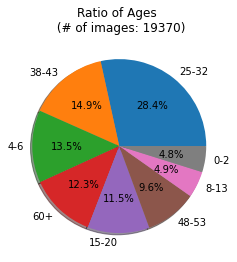

In [163]:
plt.pie(df.age.value_counts(dropna=False), shadow = True, autopct = '%1.1f%%', labels = df.age.unique())
plt.title('Ratio of Ages \n (# of images: 19370)')
#plt.savefig('img/ageratio.jpg')
#total # of images: 19370

Text(0.5, 1.0, 'Ratio of Genders \n (# of images: 19370)')

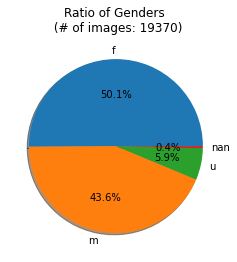

In [164]:
plt.pie(df.gender.value_counts(dropna=False), shadow = True, autopct = '%1.1f%%', labels = df.gender.unique())
plt.title('Ratio of Genders \n (# of images: 19370)')
#plt.savefig('img/genderratio.jpg')
#total # of images: 19370